In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from google.colab import drive
import random
from sklearn.metrics import mean_squared_error, confusion_matrix
import time
from sklearn.model_selection import GridSearchCV
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Code to load the data

In [ ]:
# # Task 1

# def load_train_test_imdb_data(data_dir):
#     """Loads the IMDB train/test datasets from a folder path.
#     Input:
#     data_dir: path to the "aclImdb" folder.
    
#     Returns:
#     train/test datasets as pandas dataframes.
#     """

#     data = {}
#     for split in ["train", "test"]:
#         data[split] = []
#         for sentiment in ["neg", "pos"]:
#             score = 1 if sentiment == "pos" else 0

#             path = os.path.join(data_dir, split, sentiment)
#             file_names = os.listdir(path)
#             for f_name in file_names:
#                 with open(os.path.join(path, f_name), "r") as f:
#                     review = f.read()
#                     data[split].append([review, score])

#     np.random.shuffle(data["train"])        
#     data["train"] = pd.DataFrame(data["train"],
#                                  columns=['text', 'sentiment'])
#     np.random.shuffle(data["test"])
#     data["test"] = pd.DataFrame(data["test"],
#                                 columns=['text', 'sentiment'])
#     return data["train"], data["test"]



# raw_train_data, raw_test_data = load_train_test_imdb_data(data_dir="/content/drive/MyDrive/COMP_551/A3/aclImdb/")

# NOTE

# This has been commented out and the data is being loaded from the csv files which have been generated using the above code.
# This was discussed with the TA

In [ ]:
# Temporary load data meachanism since the normal way takes way too long

raw_train_data, raw_test_data = pd.read_csv("/content/drive/MyDrive/COMP_551/A3/aclImdb/train_data.csv").drop('Unnamed: 0', axis=1), pd.read_csv("/content/drive/MyDrive/COMP_551/A3/aclImdb/test_data.csv").drop('Unnamed: 0', axis=1)

## Preprocess with lemmatization

In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Perform part-of-speech tagging to lemmatize words
    tagged_tokens = nltk.pos_tag(tokens)

    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        if tag.startswith('NN'):
            pos = wordnet.NOUN
        elif tag.startswith('VB'):
            pos = wordnet.VERB
        elif tag.startswith('JJ'):
            pos = wordnet.ADJ
        elif tag.startswith('R'):
            pos = wordnet.ADV
        else:
            pos = wordnet.NOUN  # Default to noun if part of speech is not found
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos))

    # Remove extra whitespace
    text = ' '.join(lemmatized_tokens)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

raw_train_data['text'] = raw_train_data['text'].apply(preprocess_text)
raw_test_data['text'] = raw_test_data['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Creating the model

In [ ]:
class NaiveBayes:

  def __init__(self, alpha = 1):
    self.alpha = 1
    self.vocabulary = None
    self.token_prob_0_log = None
    self.token_prob_1_log = None
    self.positive_prior = None
    self.negative_prior = None
    return
  
  def fit(self, x_train, y_train):

    # Creating a list of documents
    documents = x_train['text']

    # Initializing CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')

    # Fitting the vectorizer on the documents
    vectorizer.fit(documents)

    # Getting the vocabulary
    self.vocabulary = vectorizer.vocabulary_

    # Transforming the documents into a document-term matrix
    doc_term_matrix = vectorizer.transform(documents)

    # ASK: doc_term_matrix contains tokenized version of each sentence, right?
    y_train = y_train

    token_count_0 = np.array(doc_term_matrix[y_train == 0].sum(axis=0))[0] + self.alpha # alpha is being added for Laplace transform

    # Count of each token in the training data for sentiment=1
    token_count_1 = np.array(doc_term_matrix[y_train == 1].sum(axis=0))[0] + self.alpha

    # Total count of all tokens in the training data for sentiment=0
    total_tokens_0 = np.sum(token_count_0)

    # Total count of all tokens in the training data for sentiment=1
    total_tokens_1 = np.sum(token_count_1)

    # Probability of each token in vocab given sentiment=0
    self.token_prob_0_log = np.log(token_count_0 / total_tokens_0)

    # Probability of each token in vocab given sentiment=1
    self.token_prob_1_log = np.log(token_count_1 / total_tokens_1)
    
    # prior calculation
    positive_count = np.sum(y_train)
    negative_count = len(y_train) - positive_count
    self.positive_prior = positive_count/len(y_train)
    self.negative_prior = negative_count/len(y_train)

  def predict(self, x_test, y_test):

    y_pred = []

    for i in range(len(x_test)):

      new_sentence = str(x_test['text'][i])

      # Getting the indices of the tokens in the vocabulary, ignoring any words not in the vocabulary
      token_indices = [self.vocabulary.get(word, None) for word in new_sentence.split()]
      token_indices = [i for i in token_indices if i is not None]

      # Get the probabilities of the tokens given sentiment=0
      p_sentence_given_sentiment_0 = []
      for token_index in token_indices:
            prob = self.token_prob_0_log[token_index]
            p_sentence_given_sentiment_0.append(prob)

      # Get the probabilities of the tokens given sentiment=1
      p_sentence_given_sentiment_1 = []
      for token_index in token_indices:
          prob = self.token_prob_1_log[token_index]
          p_sentence_given_sentiment_1.append(prob)

      # Actual prediction code follows below

      p_sentiment_0_given_sentence = np.log(self.negative_prior) + np.sum(p_sentence_given_sentiment_0)
      p_sentiment_1_given_sentence = np.log(self.positive_prior) + np.sum(p_sentence_given_sentiment_1)
      if p_sentiment_0_given_sentence>p_sentiment_1_given_sentence:
        y_pred.append(0)
      else:
        y_pred.append(1)
    return y_pred

  def evaluate_acc(self, y_pred, y_true):
    return accuracy_score(y_pred=y_pred, y_true=y_true)

# Training and evaluating the model

In [ ]:
model = NaiveBayes()
model.fit(raw_train_data, y_train=raw_train_data['sentiment'])

In [ ]:
# Train accuracy

y_pred = model.predict(raw_train_data, raw_train_data['sentiment'])

In [ ]:
model.evaluate_acc(y_pred=y_pred, y_true=raw_train_data['sentiment'])

0.91944

In [ ]:
# Test accuracy

y_pred = model.predict(raw_test_data, raw_test_data['sentiment'])

In [ ]:
model.evaluate_acc(y_pred=y_pred, y_true=raw_test_data['sentiment'])

0.81756

In [ ]:
mat=confusion_matrix(y_pred=y_pred, y_true=raw_test_data['sentiment'])

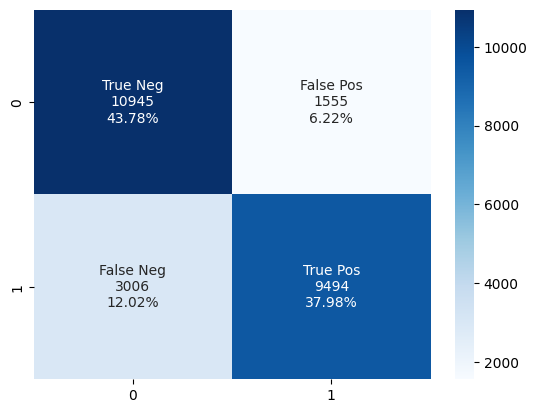

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     mat.flatten()/np.sum(mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mat, annot=labels, fmt="", cmap='Blues')
plt.show()

# Training and evaluating the model with TFIDF-vectorizer

In [ ]:
class NaiveBayesTFIDF:

  def __init__(self, alpha = 1):
    self.alpha = 1
    self.vocabulary = None
    self.token_prob_0_log = None
    self.token_prob_1_log = None
    self.positive_prior = None
    self.negative_prior = None
    return
  
  def fit(self, x_train, y_train):
      # Creating a list of documents
      documents = x_train['text']

      # Initializing TfidfVectorizer
      vectorizer = TfidfVectorizer(stop_words='english')

      # Fitting the vectorizer on the documents
      vectorizer.fit(documents)

      # Getting the vocabulary
      self.vocabulary = vectorizer.vocabulary_

      # Transforming the documents into a TF-IDF weighted document-term matrix
      tf_idf_matrix = vectorizer.transform(documents)

      # ASK: doc_term_matrix contains tokenized version of each sentence, right?
      y_train = y_train

      token_count_0 = np.array(tf_idf_matrix[y_train == 0].sum(axis=0))[0] + self.alpha # alpha is being added for Laplace transform

      # Count of each token in the training data for sentiment=1
      token_count_1 = np.array(tf_idf_matrix[y_train == 1].sum(axis=0))[0] + self.alpha

      # Total count of all tokens in the training data for sentiment=0
      total_tokens_0 = np.sum(token_count_0)

      # Total count of all tokens in the training data for sentiment=1
      total_tokens_1 = np.sum(token_count_1)

      # Probability of each token in vocab given sentiment=0
      self.token_prob_0_log = np.log(token_count_0 / total_tokens_0)

      # Probability of each token in vocab given sentiment=1
      self.token_prob_1_log = np.log(token_count_1 / total_tokens_1)
      
      # prior calculation
      positive_count = np.sum(y_train)
      negative_count = len(y_train) - positive_count
      self.positive_prior = positive_count/len(y_train)
      self.negative_prior = negative_count/len(y_train)


  def predict(self, x_test, y_test):

    y_pred = []

    for i in range(len(x_test)):

      new_sentence = str(x_test['text'][i])

      # Getting the indices of the tokens in the vocabulary, ignoring any words not in the vocabulary
      token_indices = [self.vocabulary.get(word, None) for word in new_sentence.split()]
      token_indices = [i for i in token_indices if i is not None]

      # Get the probabilities of the tokens given sentiment=0
      p_sentence_given_sentiment_0 = []
      for token_index in token_indices:
            prob = self.token_prob_0_log[token_index]
            p_sentence_given_sentiment_0.append(prob)

      # Get the probabilities of the tokens given sentiment=1
      p_sentence_given_sentiment_1 = []
      for token_index in token_indices:
          prob = self.token_prob_1_log[token_index]
          p_sentence_given_sentiment_1.append(prob)

      # Actual prediction code follows below

      p_sentiment_0_given_sentence = np.log(self.negative_prior) + np.sum(p_sentence_given_sentiment_0)
      p_sentiment_1_given_sentence = np.log(self.positive_prior) + np.sum(p_sentence_given_sentiment_1)
      if p_sentiment_0_given_sentence>p_sentiment_1_given_sentence:
        y_pred.append(0)
      else:
        y_pred.append(1)
    return y_pred

  def evaluate_acc(self, y_pred, y_true):
    return accuracy_score(y_pred=y_pred, y_true=y_true)

In [ ]:
model = NaiveBayesTFIDF()
model.fit(raw_train_data, y_train=raw_train_data['sentiment'])

In [ ]:
# Train accuracy

y_pred = model.predict(raw_train_data, raw_train_data['sentiment'])
model.evaluate_acc(y_pred=y_pred, y_true=raw_train_data['sentiment'])

0.8938

In [ ]:
# Test accuracy

y_pred = model.predict(raw_test_data, raw_test_data['sentiment'])
model.evaluate_acc(y_pred=y_pred, y_true=raw_test_data['sentiment'])

0.82476

In [ ]:
mat=confusion_matrix(y_pred=y_pred, y_true=raw_test_data['sentiment'])

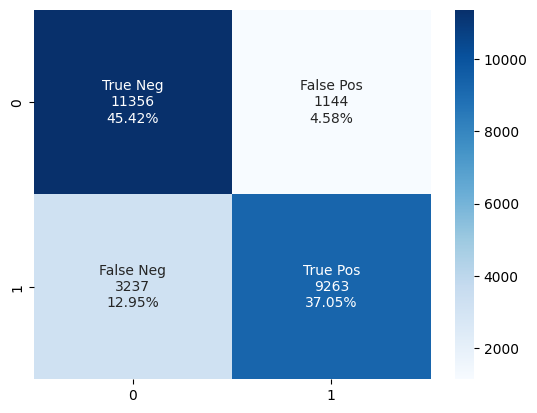

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     mat.flatten()/np.sum(mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mat, annot=labels, fmt="", cmap='Blues')
plt.show()

## Training and testing the model without lemmatization

In [ ]:
# Temporary load data meachanism since the normal way takes way too long

raw_train_data, raw_test_data = pd.read_csv("/content/drive/MyDrive/COMP_551/A3/aclImdb/train_data.csv").drop('Unnamed: 0', axis=1), pd.read_csv("/content/drive/MyDrive/COMP_551/A3/aclImdb/test_data.csv").drop('Unnamed: 0', axis=1)

In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    return text

raw_train_data['text'] = raw_train_data['text'].apply(preprocess_text)
raw_test_data['text'] = raw_test_data['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
class NaiveBayes:

  def __init__(self, alpha = 1):
    self.alpha = 1
    self.vocabulary = None
    self.token_prob_0_log = None
    self.token_prob_1_log = None
    self.positive_prior = None
    self.negative_prior = None
    return
  
  def fit(self, x_train, y_train):

    # Creating a list of documents
    documents = x_train['text']

    # Initializing CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')

    # Fitting the vectorizer on the documents
    vectorizer.fit(documents)

    # Getting the vocabulary
    self.vocabulary = vectorizer.vocabulary_

    # Transforming the documents into a document-term matrix
    doc_term_matrix = vectorizer.transform(documents)

    # ASK: doc_term_matrix contains tokenized version of each sentence, right?
    y_train = y_train

    token_count_0 = np.array(doc_term_matrix[y_train == 0].sum(axis=0))[0] + self.alpha # alpha is being added for Laplace transform

    # Count of each token in the training data for sentiment=1
    token_count_1 = np.array(doc_term_matrix[y_train == 1].sum(axis=0))[0] + self.alpha

    # Total count of all tokens in the training data for sentiment=0
    total_tokens_0 = np.sum(token_count_0)

    # Total count of all tokens in the training data for sentiment=1
    total_tokens_1 = np.sum(token_count_1)

    # Probability of each token in vocab given sentiment=0
    self.token_prob_0_log = np.log(token_count_0 / total_tokens_0)

    # Probability of each token in vocab given sentiment=1
    self.token_prob_1_log = np.log(token_count_1 / total_tokens_1)
    
    # prior calculation
    positive_count = np.sum(y_train)
    negative_count = len(y_train) - positive_count
    self.positive_prior = positive_count/len(y_train)
    self.negative_prior = negative_count/len(y_train)

  def predict(self, x_test, y_test):

    y_pred = []

    for i in range(len(x_test)):

      new_sentence = str(x_test['text'][i])

      # Getting the indices of the tokens in the vocabulary, ignoring any words not in the vocabulary
      token_indices = [self.vocabulary.get(word, None) for word in new_sentence.split()]
      token_indices = [i for i in token_indices if i is not None]

      # Get the probabilities of the tokens given sentiment=0
      p_sentence_given_sentiment_0 = []
      for token_index in token_indices:
            prob = self.token_prob_0_log[token_index]
            p_sentence_given_sentiment_0.append(prob)

      # Get the probabilities of the tokens given sentiment=1
      p_sentence_given_sentiment_1 = []
      for token_index in token_indices:
          prob = self.token_prob_1_log[token_index]
          p_sentence_given_sentiment_1.append(prob)

      # Actual prediction code follows below

      p_sentiment_0_given_sentence = np.log(self.negative_prior) + np.sum(p_sentence_given_sentiment_0)
      p_sentiment_1_given_sentence = np.log(self.positive_prior) + np.sum(p_sentence_given_sentiment_1)
      if p_sentiment_0_given_sentence>p_sentiment_1_given_sentence:
        y_pred.append(0)
      else:
        y_pred.append(1)
    return y_pred

  def evaluate_acc(self, y_pred, y_true):
    return accuracy_score(y_pred=y_pred, y_true=y_true)

In [ ]:
model = NaiveBayes()
model.fit(raw_train_data, y_train=raw_train_data['sentiment'])

In [ ]:
# Train accuracy

y_pred = model.predict(raw_train_data, raw_train_data['sentiment'])

In [ ]:
model.evaluate_acc(y_pred=y_pred, y_true=raw_train_data['sentiment'])

0.92604

In [ ]:
# Test accuracy

y_pred = model.predict(raw_test_data, raw_test_data['sentiment'])

In [ ]:
model.evaluate_acc(y_pred=y_pred, y_true=raw_test_data['sentiment'])

0.82448

In [ ]:
mat=confusion_matrix(y_pred=y_pred, y_true=raw_test_data['sentiment'])

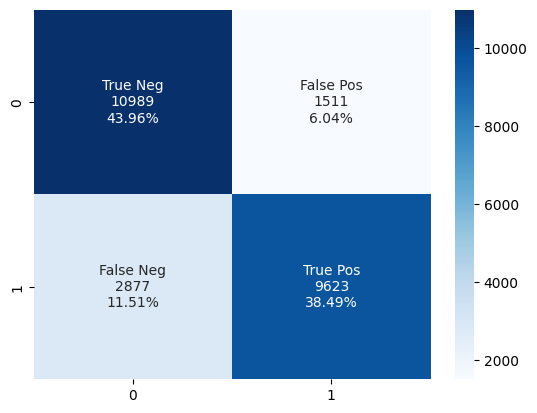

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     mat.flatten()/np.sum(mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mat, annot=labels, fmt="", cmap='Blues')
plt.show()